In [1]:
import os # para criar pastas
from matplotlib import pyplot as plt # para mostrar imagens
from keras.datasets import cifar10
import keras.utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import Callback 
from keras.models import load_model
from keras.layers.noise import AlphaDropout
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from IPython.display import clear_output
import math

c:\users\jordy\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if not os.path.exists('tmp'): 
    os.makedirs('tmp')        

In [3]:
(x_train, y_train), (x_temp, y_temp) = cifar10.load_data()

# Separando Dataset
split = math.ceil(0.5 * x_temp.shape[0]) # Separar 70% das imagens usadas para treino

x_test = x_temp[:split]
y_test = y_temp[:split]

x_val = x_temp[split:]
y_val = y_temp[split:]

num_train, img_rows, img_cols, img_channels =  x_train.shape
num_test, _, _, _ =  x_test.shape

num_classes = len(np.unique(y_train))

# Convert class vectors to binary class matrices. (one-hot encode)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
datagen.fit(x_train)

In [4]:
lrn = 1.0e-4      # Learning rate
epochs = 100      
batch_size = 500
activ = 'selu'

logs_path = '/tmp/tensorflow_logs/example/' # caminho do log para o tensorboard

In [5]:
def modelo():
    model = Sequential()    
    model.add(Conv2D(64,(5,5), activation=activ, kernel_initializer='lecun_normal',
             padding='same', input_shape=(img_rows, img_cols, img_channels)))
    model.add(Conv2D(64,(3,3), activation=activ,kernel_initializer='lecun_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(AlphaDropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128,(2,2), activation=activ,kernel_initializer='lecun_normal'))
    model.add(Conv2D(128,(2,2), activation=activ,kernel_initializer='lecun_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(AlphaDropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256,(2,2), activation=activ,kernel_initializer='lecun_normal'))
    model.add(Conv2D(256,(2,2), activation=activ,kernel_initializer='lecun_normal'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(AlphaDropout(0.5))
    model.add(BatchNormalization())
       
    model.add(Flatten())
    
    model.add(Dense(4096, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.5))
    model.add(Dense(4096, activation=activ,kernel_initializer='lecun_normal'))
    model.add(AlphaDropout(0.5))
    model.add(Dense(num_classes, kernel_initializer='lecun_normal',activation='softmax'))
    
    model.summary()
    return model

In [6]:
modelo = modelo()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        9472      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       65664     
__________

In [7]:
modelo.compile(loss='categorical_crossentropy',
               optimizer=Adam(lr=lrn),
               metrics=['accuracy'])

In [8]:
checkpoint = ModelCheckpoint('meuModelo.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [9]:
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=0,
                      verbose=0, 
                      mode='auto')

In [10]:
class LivePlot(keras.callbacks.Callback):
    
    def _init_(self, metric):
        self.metric = 'accuracy'
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.train_metric_history = []
        self.val_metric_history = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):   
        #clear_output(wait=True)
        self.logs.append(logs)
        self.x.append(self.i)
        self.train_metric_history.append(logs.get('acc'))
        self.val_metric_history.append(logs.get('val_acc'))
        self.i += 1        
        
        plt.plot(self.x, self.train_metric_history, label='acc')
        plt.plot(self.x, self.val_metric_history, label='val_acc')
        plt.legend()
        plt.show();        
plot = LivePlot()

Train on 50000 samples, validate on 5000 samples
Epoch 1/100
50000/50000 [==============================] - 26s 520us/step - loss: 1.5527 - acc: 0.4436 - val_loss: 7.0735 - val_acc: 0.3740


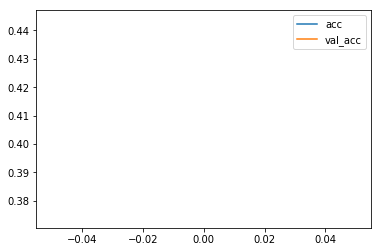

Epoch 2/100
50000/50000 [==============================] - 26s 522us/step - loss: 1.4454 - acc: 0.4829 - val_loss: 8.3258 - val_acc: 0.3018


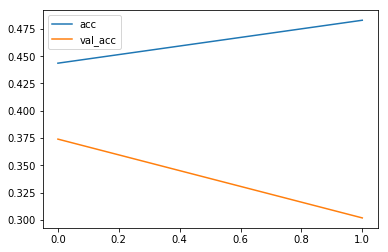

Epoch 3/100
50000/50000 [==============================] - 26s 520us/step - loss: 1.3479 - acc: 0.5175 - val_loss: 7.0381 - val_acc: 0.3548


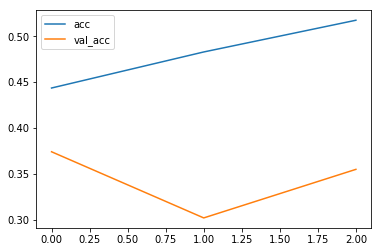

Epoch 4/100
50000/50000 [==============================] - 26s 521us/step - loss: 1.2646 - acc: 0.5454 - val_loss: 7.5122 - val_acc: 0.3162


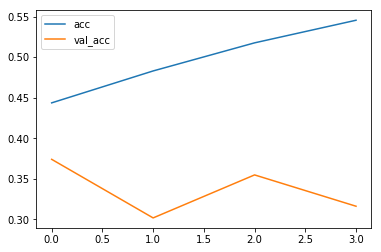

Epoch 5/100
50000/50000 [==============================] - 26s 523us/step - loss: 1.2103 - acc: 0.5690 - val_loss: 7.3643 - val_acc: 0.3286


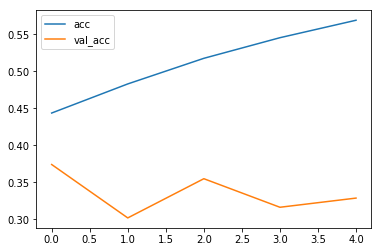

Epoch 6/100
50000/50000 [==============================] - 26s 523us/step - loss: 1.1540 - acc: 0.5902 - val_loss: 5.2673 - val_acc: 0.4420


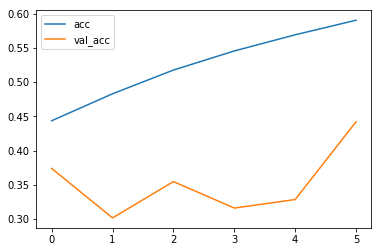

Epoch 7/100
50000/50000 [==============================] - 26s 524us/step - loss: 1.1108 - acc: 0.6043 - val_loss: 5.4697 - val_acc: 0.4180


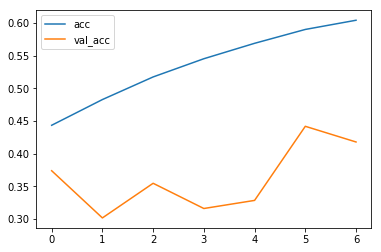

Epoch 8/100
50000/50000 [==============================] - 26s 528us/step - loss: 1.0722 - acc: 0.6181 - val_loss: 5.4583 - val_acc: 0.4358


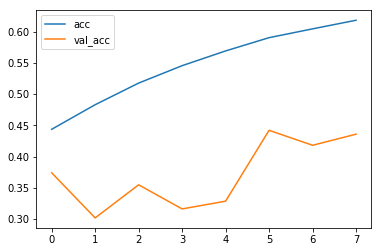

Epoch 9/100
50000/50000 [==============================] - 26s 527us/step - loss: 1.0391 - acc: 0.6323 - val_loss: 7.6662 - val_acc: 0.3156


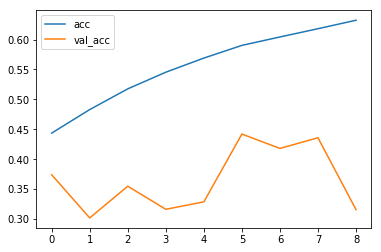

Epoch 10/100
50000/50000 [==============================] - 26s 530us/step - loss: 1.0020 - acc: 0.6442 - val_loss: 8.0290 - val_acc: 0.3008


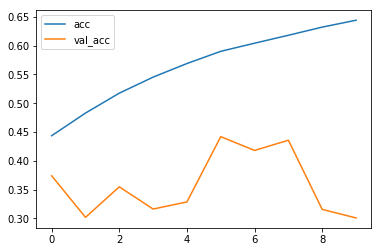

Epoch 11/100
50000/50000 [==============================] - 26s 526us/step - loss: 0.9726 - acc: 0.6542 - val_loss: 6.5966 - val_acc: 0.3832


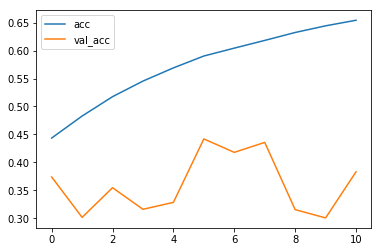

Epoch 12/100
50000/50000 [==============================] - 26s 529us/step - loss: 0.9443 - acc: 0.6642 - val_loss: 3.9607 - val_acc: 0.5818


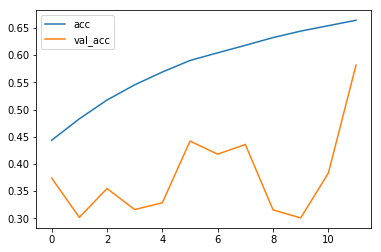

Epoch 13/100
50000/50000 [==============================] - 27s 530us/step - loss: 0.9148 - acc: 0.6738 - val_loss: 4.4209 - val_acc: 0.5370


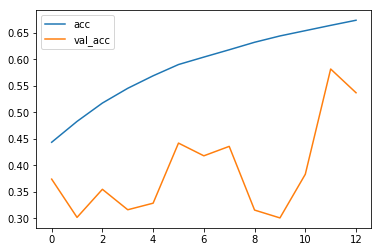

Epoch 14/100
50000/50000 [==============================] - 27s 531us/step - loss: 0.8908 - acc: 0.6821 - val_loss: 5.7684 - val_acc: 0.4450


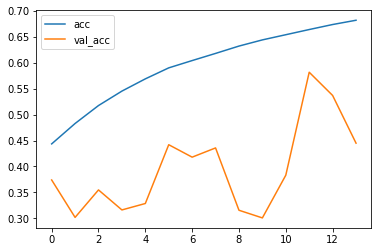

Epoch 15/100
50000/50000 [==============================] - 26s 527us/step - loss: 0.8617 - acc: 0.6949 - val_loss: 7.2243 - val_acc: 0.3624


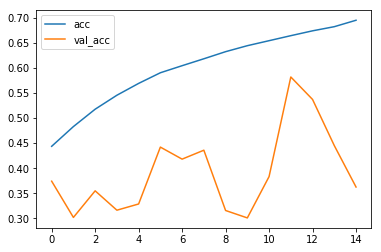

Epoch 16/100
50000/50000 [==============================] - 26s 529us/step - loss: 0.8442 - acc: 0.7016 - val_loss: 6.7019 - val_acc: 0.3944


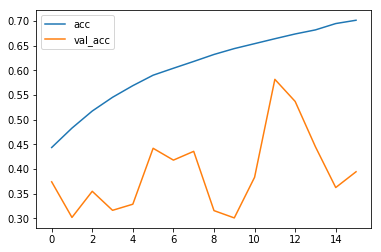

Epoch 17/100
50000/50000 [==============================] - 27s 531us/step - loss: 0.8179 - acc: 0.7105 - val_loss: 5.0913 - val_acc: 0.5192


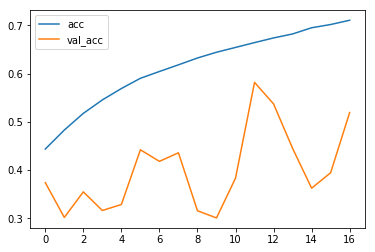

Epoch 18/100
50000/50000 [==============================] - 27s 531us/step - loss: 0.7971 - acc: 0.7164 - val_loss: 6.1565 - val_acc: 0.4696


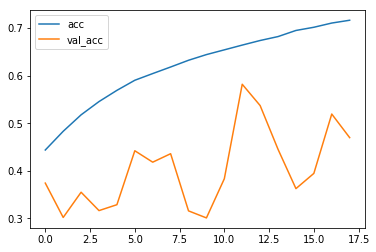

Epoch 19/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.7774 - acc: 0.7215 - val_loss: 5.0806 - val_acc: 0.5176


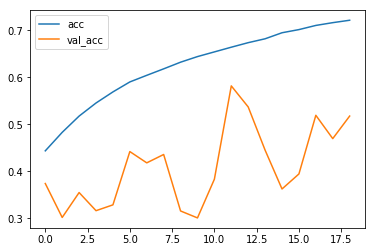

Epoch 20/100
50000/50000 [==============================] - 27s 531us/step - loss: 0.7602 - acc: 0.7300 - val_loss: 5.4984 - val_acc: 0.5030


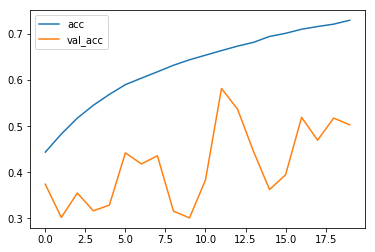

Epoch 21/100
50000/50000 [==============================] - 26s 529us/step - loss: 0.7416 - acc: 0.7368 - val_loss: 5.0983 - val_acc: 0.5480


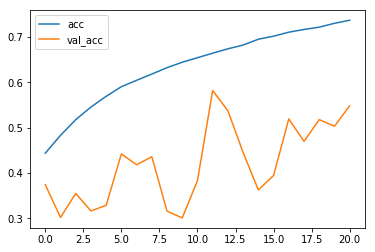

Epoch 22/100
50000/50000 [==============================] - 26s 525us/step - loss: 0.7249 - acc: 0.7426 - val_loss: 5.2436 - val_acc: 0.5436


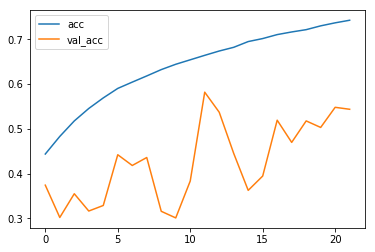

Epoch 23/100
50000/50000 [==============================] - 26s 525us/step - loss: 0.7019 - acc: 0.7520 - val_loss: 4.7557 - val_acc: 0.5686


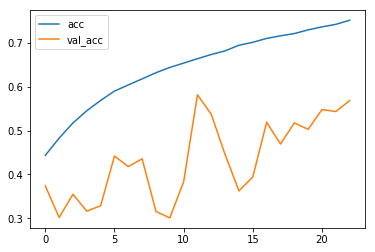

Epoch 24/100
50000/50000 [==============================] - 26s 529us/step - loss: 0.6836 - acc: 0.7583 - val_loss: 4.6077 - val_acc: 0.5758


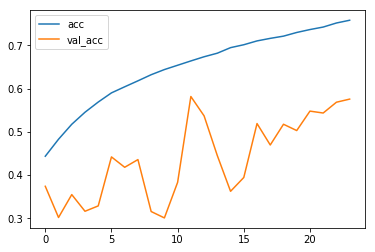

Epoch 25/100
50000/50000 [==============================] - 26s 527us/step - loss: 0.6738 - acc: 0.7607 - val_loss: 5.2371 - val_acc: 0.5586


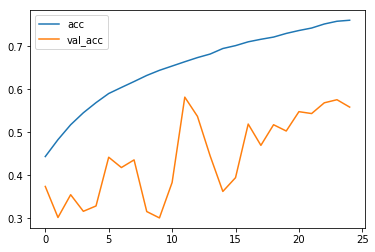

Epoch 26/100
50000/50000 [==============================] - 26s 527us/step - loss: 0.6560 - acc: 0.7679 - val_loss: 6.8263 - val_acc: 0.4408


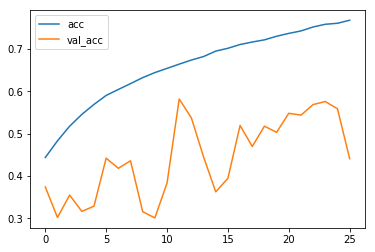

Epoch 27/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.6384 - acc: 0.7723 - val_loss: 5.7356 - val_acc: 0.5238


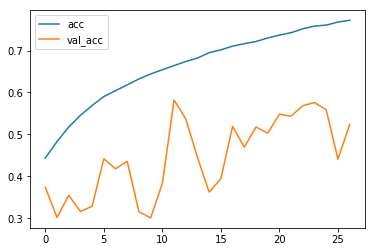

Epoch 28/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.6238 - acc: 0.7796 - val_loss: 4.9614 - val_acc: 0.5802


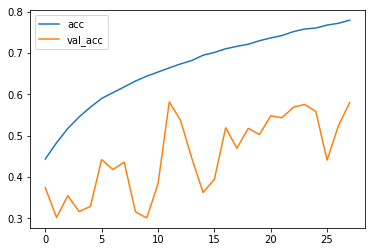

Epoch 29/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.6137 - acc: 0.7807 - val_loss: 5.9598 - val_acc: 0.5240


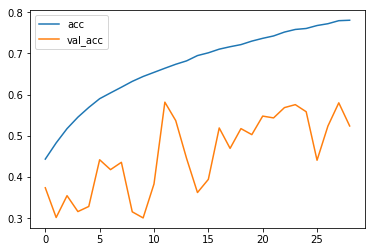

Epoch 30/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.5904 - acc: 0.7901 - val_loss: 5.2134 - val_acc: 0.5758


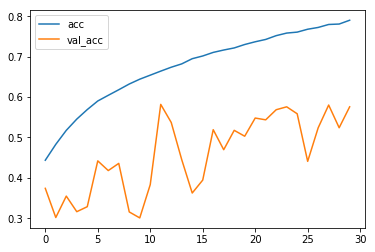

Epoch 31/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.5798 - acc: 0.7941 - val_loss: 5.7659 - val_acc: 0.5426


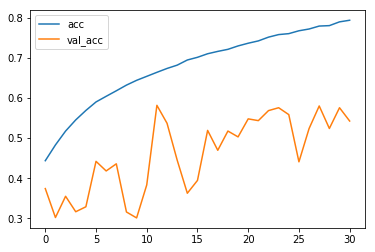

Epoch 32/100
50000/50000 [==============================] - 27s 541us/step - loss: 0.5646 - acc: 0.7983 - val_loss: 6.4116 - val_acc: 0.5082


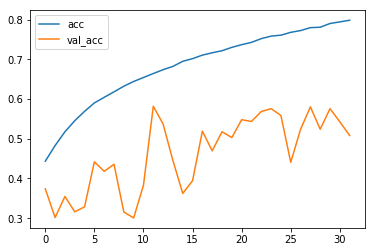

Epoch 33/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.5499 - acc: 0.8046 - val_loss: 6.4404 - val_acc: 0.5156


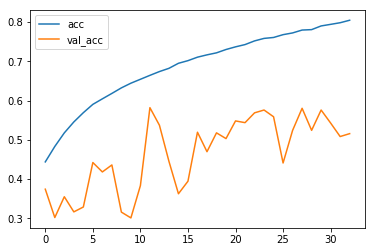

Epoch 34/100
50000/50000 [==============================] - 27s 534us/step - loss: 0.5365 - acc: 0.8083 - val_loss: 7.0750 - val_acc: 0.4822


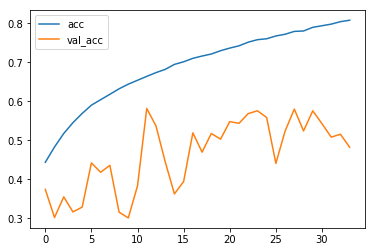

Epoch 35/100
50000/50000 [==============================] - 27s 531us/step - loss: 0.5269 - acc: 0.8118 - val_loss: 7.1783 - val_acc: 0.4544


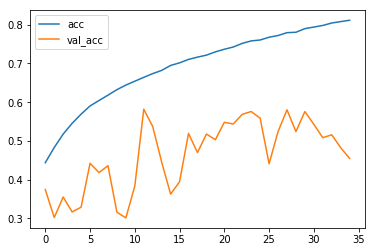

Epoch 36/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.5123 - acc: 0.8170 - val_loss: 7.4208 - val_acc: 0.4602


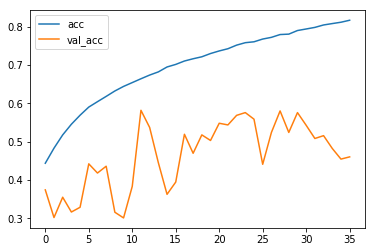

Epoch 37/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.5033 - acc: 0.8216 - val_loss: 8.7886 - val_acc: 0.3696


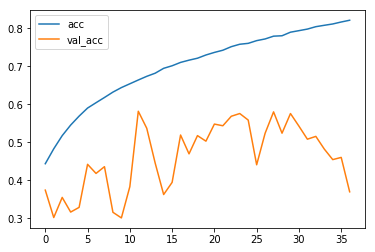

Epoch 38/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.4890 - acc: 0.8256 - val_loss: 7.4916 - val_acc: 0.4604


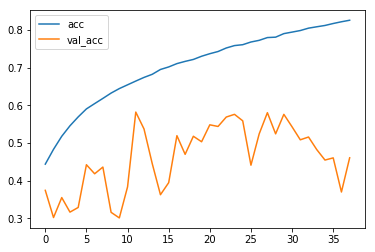

Epoch 39/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.4749 - acc: 0.8300 - val_loss: 7.2879 - val_acc: 0.4764


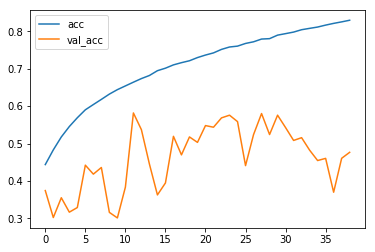

Epoch 40/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.4619 - acc: 0.8335 - val_loss: 8.1516 - val_acc: 0.4288


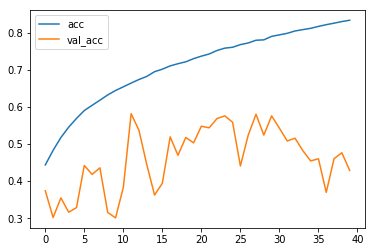

Epoch 41/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.4534 - acc: 0.8376 - val_loss: 8.2694 - val_acc: 0.4160


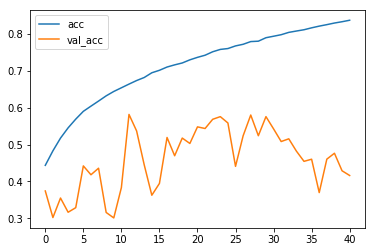

Epoch 42/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.4337 - acc: 0.8455 - val_loss: 8.8846 - val_acc: 0.3836


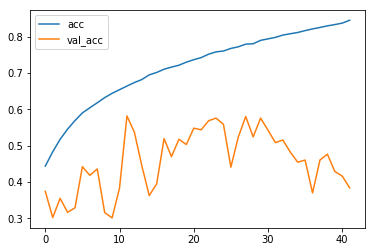

Epoch 43/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.4272 - acc: 0.8459 - val_loss: 8.8395 - val_acc: 0.3918


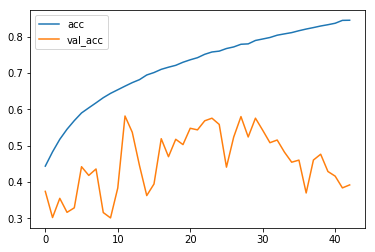

Epoch 44/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.4143 - acc: 0.8524 - val_loss: 7.0203 - val_acc: 0.4992


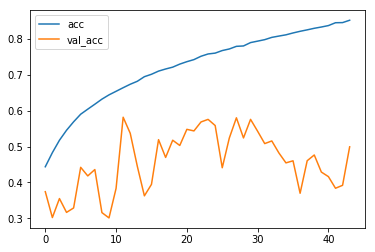

Epoch 45/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.4043 - acc: 0.8545 - val_loss: 8.7765 - val_acc: 0.3938


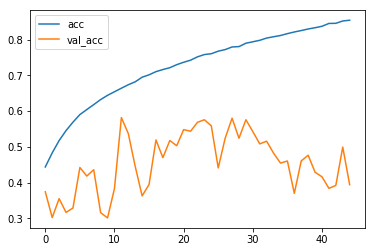

Epoch 46/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.3894 - acc: 0.8602 - val_loss: 9.5182 - val_acc: 0.3664


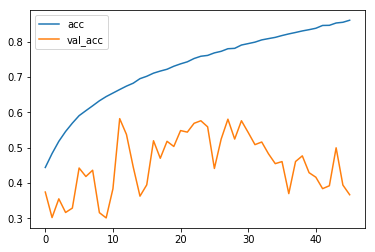

Epoch 47/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.3840 - acc: 0.8623 - val_loss: 8.0965 - val_acc: 0.4408


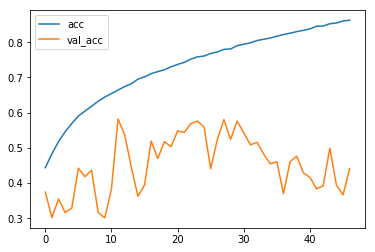

Epoch 48/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.3696 - acc: 0.8677 - val_loss: 7.5105 - val_acc: 0.4804


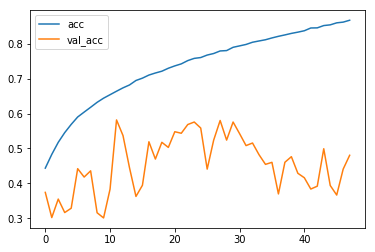

Epoch 49/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.3587 - acc: 0.8726 - val_loss: 7.8959 - val_acc: 0.4548


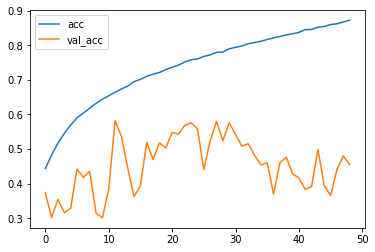

Epoch 50/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.3464 - acc: 0.8734 - val_loss: 7.5829 - val_acc: 0.4750


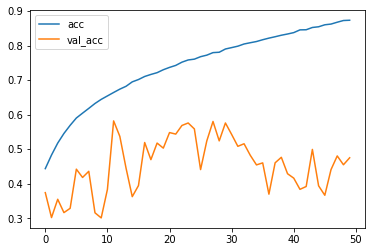

Epoch 51/100
50000/50000 [==============================] - 27s 535us/step - loss: 0.3316 - acc: 0.8809 - val_loss: 9.5270 - val_acc: 0.3668


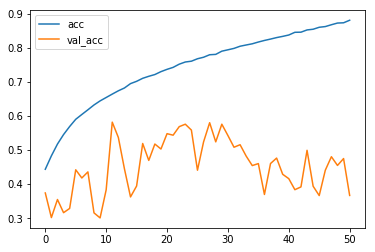

Epoch 52/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.3260 - acc: 0.8833 - val_loss: 6.2917 - val_acc: 0.5636


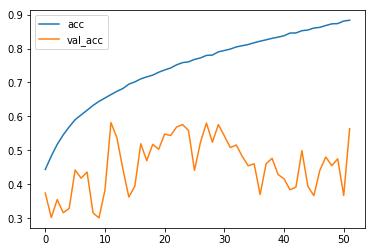

Epoch 53/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.3183 - acc: 0.8842 - val_loss: 6.7641 - val_acc: 0.5338


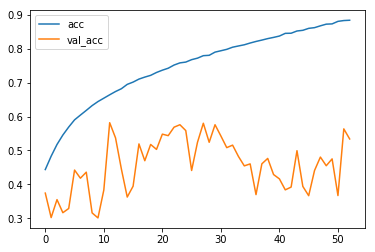

Epoch 54/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.3048 - acc: 0.8903 - val_loss: 7.8435 - val_acc: 0.4712


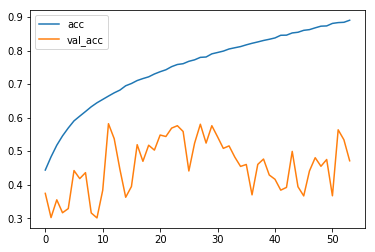

Epoch 55/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.2949 - acc: 0.8940 - val_loss: 9.1117 - val_acc: 0.3864


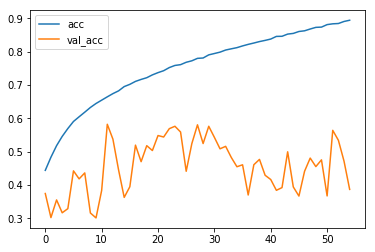

Epoch 56/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.2833 - acc: 0.8964 - val_loss: 8.1197 - val_acc: 0.4494


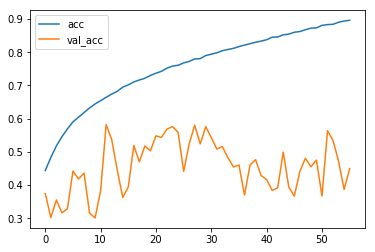

Epoch 57/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.2730 - acc: 0.9011 - val_loss: 8.1705 - val_acc: 0.4468


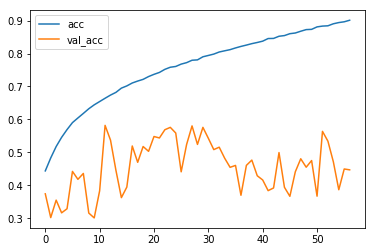

Epoch 58/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.2633 - acc: 0.9045 - val_loss: 7.8611 - val_acc: 0.4724


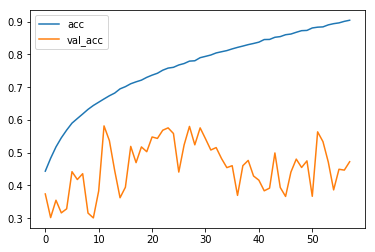

Epoch 59/100
50000/50000 [==============================] - 27s 534us/step - loss: 0.2593 - acc: 0.9066 - val_loss: 8.1097 - val_acc: 0.4566


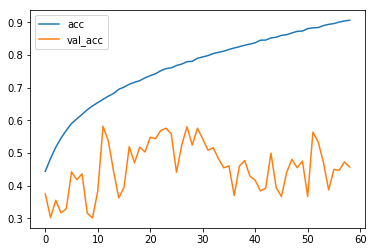

Epoch 60/100
50000/50000 [==============================] - 27s 533us/step - loss: 0.2497 - acc: 0.9099 - val_loss: 7.3334 - val_acc: 0.5034


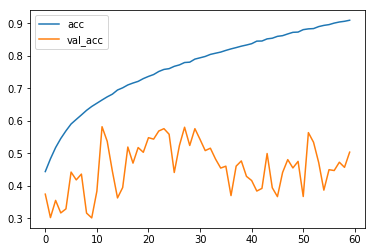

Epoch 61/100
50000/50000 [==============================] - 27s 534us/step - loss: 0.2379 - acc: 0.9136 - val_loss: 8.2153 - val_acc: 0.4544


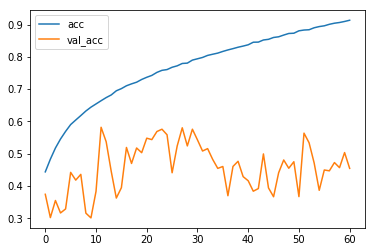

Epoch 62/100
50000/50000 [==============================] - 27s 535us/step - loss: 0.2307 - acc: 0.9154 - val_loss: 8.4263 - val_acc: 0.4370


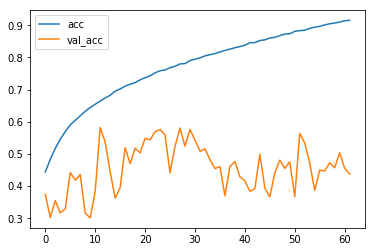

Epoch 63/100
50000/50000 [==============================] - 27s 535us/step - loss: 0.2259 - acc: 0.9180 - val_loss: 9.1977 - val_acc: 0.3890


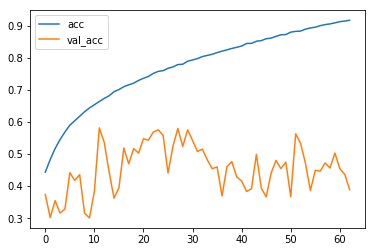

Epoch 64/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.2166 - acc: 0.9222 - val_loss: 9.6260 - val_acc: 0.3668


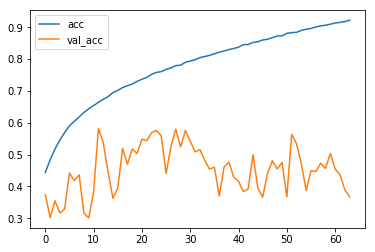

Epoch 65/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.2122 - acc: 0.9224 - val_loss: 8.7027 - val_acc: 0.4246


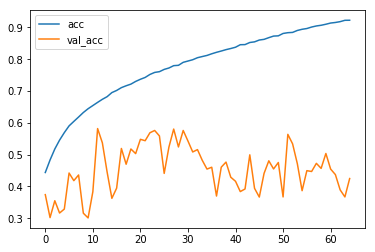

Epoch 66/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.2029 - acc: 0.9262 - val_loss: 8.1769 - val_acc: 0.4564


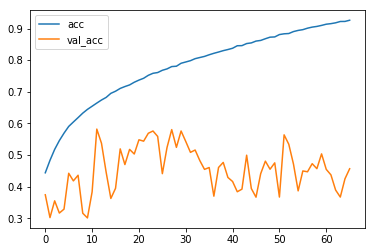

Epoch 67/100
50000/50000 [==============================] - 27s 535us/step - loss: 0.1951 - acc: 0.9292 - val_loss: 7.9410 - val_acc: 0.4704


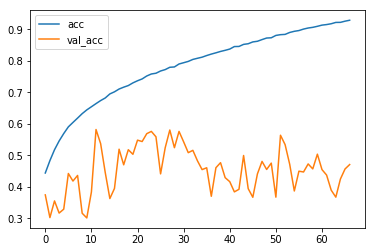

Epoch 68/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.1920 - acc: 0.9292 - val_loss: 8.0498 - val_acc: 0.4636


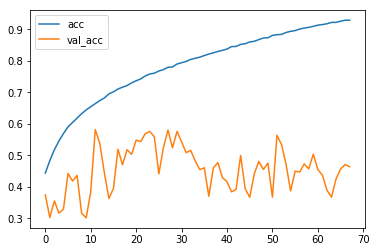

Epoch 69/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.1825 - acc: 0.9337 - val_loss: 8.6193 - val_acc: 0.4250


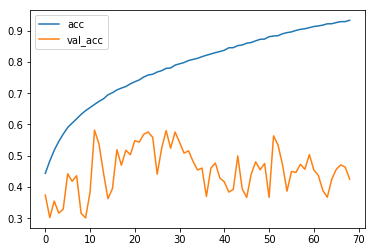

Epoch 70/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1749 - acc: 0.9366 - val_loss: 8.0013 - val_acc: 0.4682


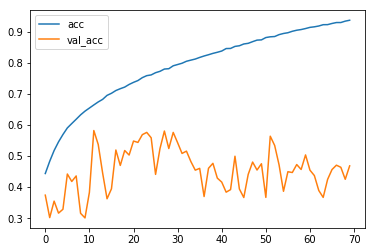

Epoch 71/100
50000/50000 [==============================] - 27s 542us/step - loss: 0.1709 - acc: 0.9374 - val_loss: 8.4486 - val_acc: 0.4410


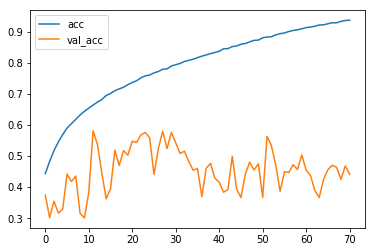

Epoch 72/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1630 - acc: 0.9400 - val_loss: 8.7675 - val_acc: 0.4182


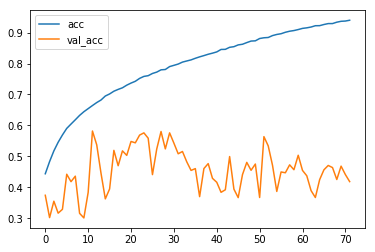

Epoch 73/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1572 - acc: 0.9434 - val_loss: 9.6011 - val_acc: 0.3698


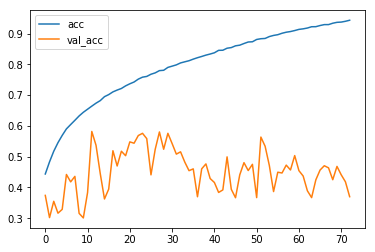

Epoch 74/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1571 - acc: 0.9435 - val_loss: 10.1877 - val_acc: 0.3368


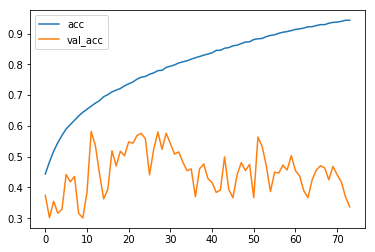

Epoch 75/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.1501 - acc: 0.9463 - val_loss: 10.0539 - val_acc: 0.3426


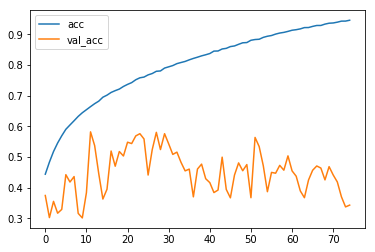

Epoch 76/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1418 - acc: 0.9494 - val_loss: 9.9790 - val_acc: 0.3524


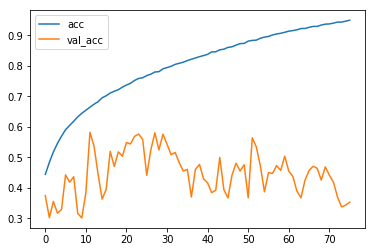

Epoch 77/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.1406 - acc: 0.9479 - val_loss: 9.5204 - val_acc: 0.3766


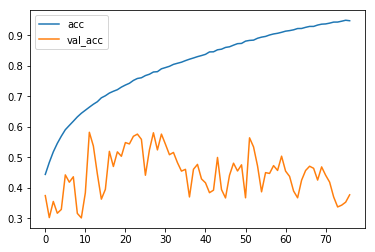

Epoch 78/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.1351 - acc: 0.9507 - val_loss: 9.8114 - val_acc: 0.3614


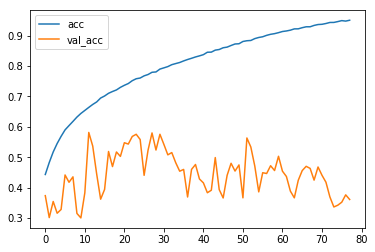

Epoch 79/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.1280 - acc: 0.9534 - val_loss: 9.7980 - val_acc: 0.3582


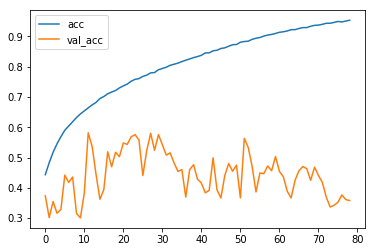

Epoch 80/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.1248 - acc: 0.9547 - val_loss: 9.0352 - val_acc: 0.4058


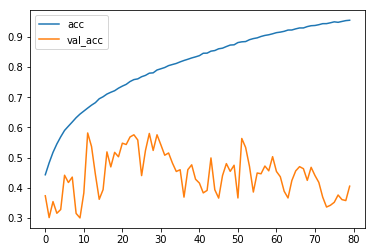

Epoch 81/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.1252 - acc: 0.9543 - val_loss: 7.9642 - val_acc: 0.4754


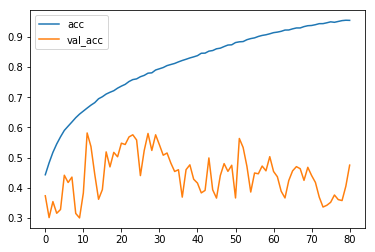

Epoch 82/100
50000/50000 [==============================] - 27s 544us/step - loss: 0.1200 - acc: 0.9568 - val_loss: 8.3033 - val_acc: 0.4560


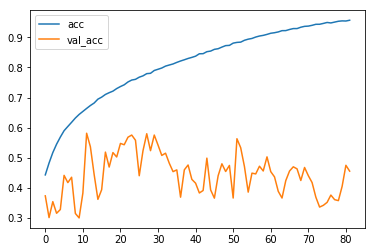

Epoch 83/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.1192 - acc: 0.9572 - val_loss: 8.6403 - val_acc: 0.4330


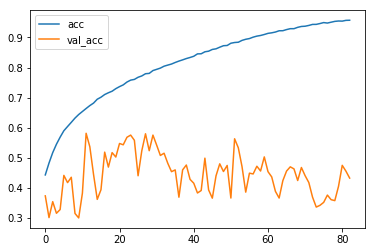

Epoch 84/100
50000/50000 [==============================] - 27s 533us/step - loss: 0.1083 - acc: 0.9610 - val_loss: 8.4671 - val_acc: 0.4432


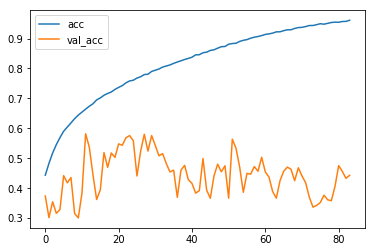

Epoch 85/100
50000/50000 [==============================] - 27s 534us/step - loss: 0.1101 - acc: 0.9600 - val_loss: 9.1911 - val_acc: 0.4022


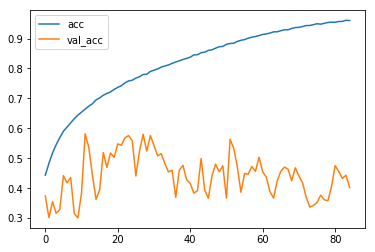

Epoch 86/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.1048 - acc: 0.9619 - val_loss: 9.5166 - val_acc: 0.3822


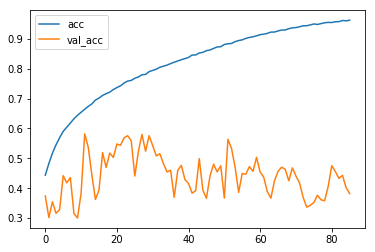

Epoch 87/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.1094 - acc: 0.9620 - val_loss: 9.1108 - val_acc: 0.4092


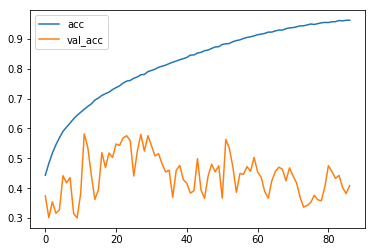

Epoch 88/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.1049 - acc: 0.9624 - val_loss: 7.9289 - val_acc: 0.4812


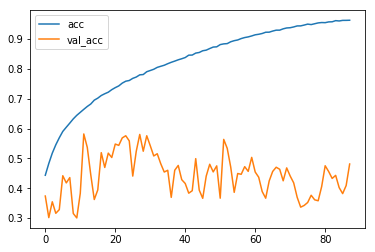

Epoch 89/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.0958 - acc: 0.9662 - val_loss: 8.9431 - val_acc: 0.4142


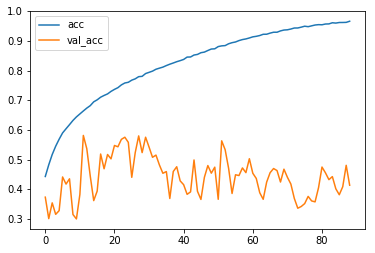

Epoch 90/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.0970 - acc: 0.9663 - val_loss: 8.5708 - val_acc: 0.4346


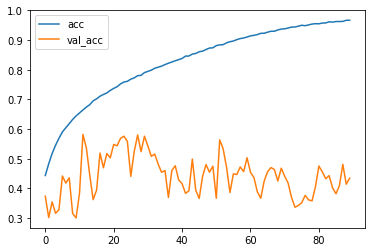

Epoch 91/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.0956 - acc: 0.9654 - val_loss: 8.8404 - val_acc: 0.4190


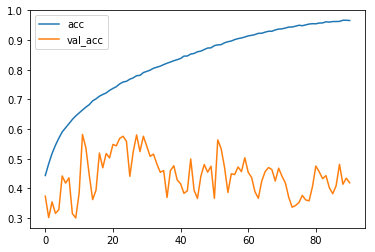

Epoch 92/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.0939 - acc: 0.9669 - val_loss: 9.2507 - val_acc: 0.3956


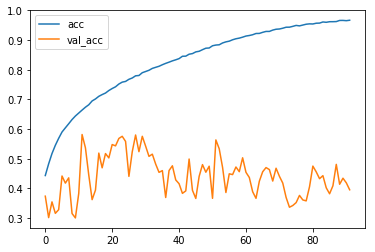

Epoch 93/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.0855 - acc: 0.9702 - val_loss: 8.7317 - val_acc: 0.4290


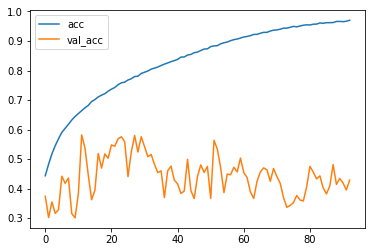

Epoch 94/100
50000/50000 [==============================] - 27s 540us/step - loss: 0.0900 - acc: 0.9677 - val_loss: 8.8391 - val_acc: 0.4182


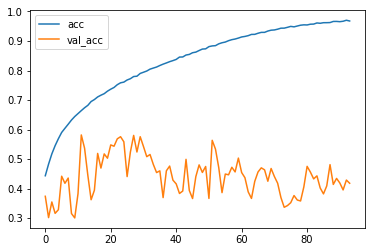

Epoch 95/100
50000/50000 [==============================] - 27s 539us/step - loss: 0.0852 - acc: 0.9703 - val_loss: 8.7356 - val_acc: 0.4274


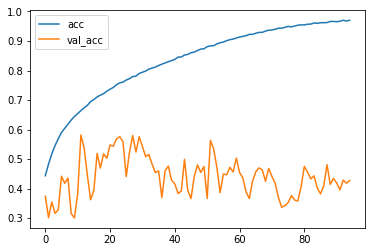

Epoch 96/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.0836 - acc: 0.9699 - val_loss: 8.5618 - val_acc: 0.4446


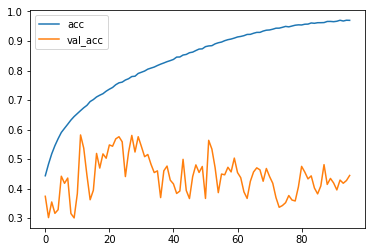

Epoch 97/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.0791 - acc: 0.9721 - val_loss: 9.0614 - val_acc: 0.4072


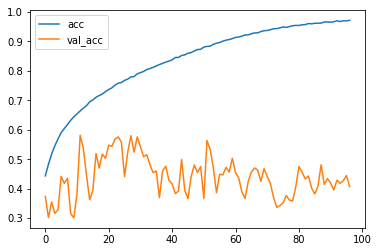

Epoch 98/100
50000/50000 [==============================] - 27s 536us/step - loss: 0.0753 - acc: 0.9731 - val_loss: 8.6385 - val_acc: 0.4366


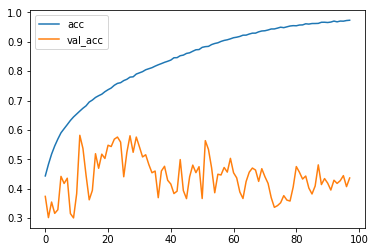

Epoch 99/100
50000/50000 [==============================] - 27s 537us/step - loss: 0.0768 - acc: 0.9726 - val_loss: 9.6423 - val_acc: 0.3724


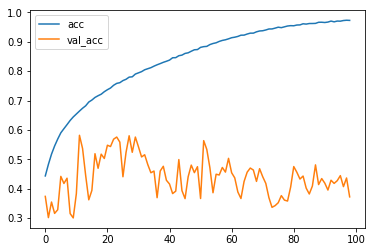

Epoch 100/100
31500/50000 [=================>............] - ETA: 9s - loss: 0.0701 - acc: 0.9753

In [ ]:
logs = modelo.fit(x_train, y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (x_test, y_test),
                 callbacks=[checkpoint,plot],
                 verbose=1)

logs = modelo.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            validation_data= (x_test, y_test),
                            steps_per_epoch=len(x_train) / 32, 
                            epochs=epochs,
                            callbacks=[checkpoint,early,plot],
                            verbose=1)

plt.subplot(211)  
plt.plot(logs.history['acc'])  
plt.plot(logs.history['val_acc'])  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

plt.subplot(212)  
plt.plot(logs.history['loss'])  
plt.plot(logs.history['val_loss'])  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower left')  
plt.show()  

In [13]:
# scores = modelo.evaluate(x_val, y_val, verbose=0)
# print("Accuracy: % .2f%%" % (scores[1]*100))